# TP6


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_swiss_roll(n_samples=1000, noise=0.0):
    """
    Generates a Swiss roll dataset.
    
    Args:
        n_samples (int): The number of points to generate.
        noise (float): The standard deviation of the Gaussian noise added to the data.
    
    Returns:
        X (np.array): The Swiss roll dataset of shape (n_samples, 3).
    """
    t = 1.5 * np.pi * (1 + 2 * np.random.rand(n_samples))
    x = t * np.cos(t)
    y = 21 * np.random.rand(n_samples)
    z = t * np.sin(t)
    X = np.vstack((x, y, z)).T
    X += noise * np.random.randn(n_samples, 3)
    return X


In [3]:
def euclidean_distances(X):
    """
    Computes the pairwise Euclidean distances between all points in X.

    Args:
        X (np.array): The input data of shape (n_samples, n_features).

    Returns:
        distances (np.array): Pairwise distance matrix of shape (n_samples, n_samples).
    """
    n_samples = X.shape[0]
    distances = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            distances[i, j] = np.linalg.norm(X[i] - X[j])
            distances[j, i] = distances[i, j]  # Symmetric matrix
    return distances

In [4]:
def find_k_neighbors_by_distances(distances, k):
    """
    Finds the indices of the k-nearest neighbors for each point.

    Args:
        distances (np.array): Pairwise distance matrix of shape (n_samples, n_samples).
        k (int): Number of neighbors.

    Returns:
        neighbors (np.array): Indices of the k-nearest neighbors for each point.
    """
    neighbors = np.argsort(distances, axis=1)[:, 1 : k + 1]  # Exclude self
    return neighbors

In [5]:
def compute_weights(data, neighbors_indices, alpha=0.01):
    """
    Computes the reconstruction weights for each point.

    Args:
        data (np.array): The input data of shape (n_samples, n_features).
        neighbors_indices (np.array): Indices of the k-nearest neighbors.
        alpha (float): Regularization term to avoid singularity.

    Returns:
        W (np.array): Weight matrix of shape (n_samples, k).
    """
    n_samples, n_features = data.shape
    k = neighbors_indices.shape[1]
    W = np.zeros((n_samples, k))

    for i in range(n_samples):
        neighbors = data[neighbors_indices[i]]
        Z = neighbors - data[i]  # Center the neighbors to the point
        C = Z @ Z.T  # Local covariance matrix
        C += alpha * np.eye(k)  # Regularization to avoid singularity

        w = np.linalg.solve(C, np.ones(k))  # Solve for weights
        W[i] = w / np.sum(w)  # Normalize weights to sum to 1

    return W

In [6]:
def lle(x, q, k=None, alpha=0.01):
    """
    Performs Locally Linear Embedding (LLE).
    
    Args:
        x (np.array): The input data of shape (n_samples, n_features).
        q (int): The target dimensionality for the embedding.
        k (int, optional): The number of nearest neighbors (if not provided, defaults to n_features + 1).
        alpha (float, optional): Regularization term (default 0.01).
    
    Returns:
        Y (np.array): The embedding of shape (n_samples, q).
    """
    n_samples, n_features = x.shape
    
    # If k is not provided, set k = n_features + 1
    if k is None:
        k = n_features + 1
    
    # Step 1: Compute pairwise distances
    distances = euclidean_distances(x)
    
    # Step 2: Find k-nearest neighbors
    neighbors_indices = find_k_neighbors_by_distances(distances, k)
    
    # Step 3: Compute the reconstruction weights
    W = compute_weights(x, neighbors_indices, alpha)
    
    # Step 4: Compute the embedding by constructing the matrix M
    M = np.zeros((n_samples, n_samples))
    
    for i in range(n_samples):
        for j in range(k):
            M[i, neighbors_indices[i, j]] -= W[i, j]
            M[neighbors_indices[i, j], i] -= W[i, j]
        M[i, i] += 1
    
    # Step 5: Solve the eigenvalue problem
    eigvals, eigvecs = np.linalg.eigh(M)
    
    # Step 6: Return the eigenvectors corresponding to the smallest q+1 eigenvalues (excluding the first one)
    Y = eigvecs[:, 1:q+1]
    
    return Y

def plot_before_after(original_data, embedding, title_before='Original Data', title_after='LLE Embedding'):
    """
    Plots the original data and the embedding for visualization with a color map.
    
    Args:
        original_data (np.array): The original high-dimensional data.
        embedding (np.array): The lower-dimensional embedding.
        title_before (str): Title for the plot of the original data.
        title_after (str): Title for the plot of the embedding.
    """
    # Original data visualization (only for 2D or 3D data)
    plt.figure(figsize=(12, 6))
    
    # Use the first dimension as color mapping for consistency in both plots
    colors = original_data[:, 0]
    
    if original_data.shape[1] == 2:
        plt.subplot(1, 2, 1)
        plt.scatter(original_data[:, 0], original_data[:, 1], c=colors, cmap='rainbow', edgecolor='k', s=40)
        plt.title(title_before)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
    
    elif original_data.shape[1] == 3:
        ax = plt.subplot(1, 2, 1, projection='3d')
        ax.scatter(original_data[:, 0], original_data[:, 1], original_data[:, 2], c=colors, cmap='rainbow', edgecolor='k', s=40)
        ax.set_title(title_before)
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.set_zlabel('Feature 3')
    
    # Embedding visualization (2D plot)
    plt.subplot(1, 2, 2)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, cmap='rainbow', edgecolor='k', s=40)
    plt.title(title_after)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    
    plt.tight_layout()
    plt.show()


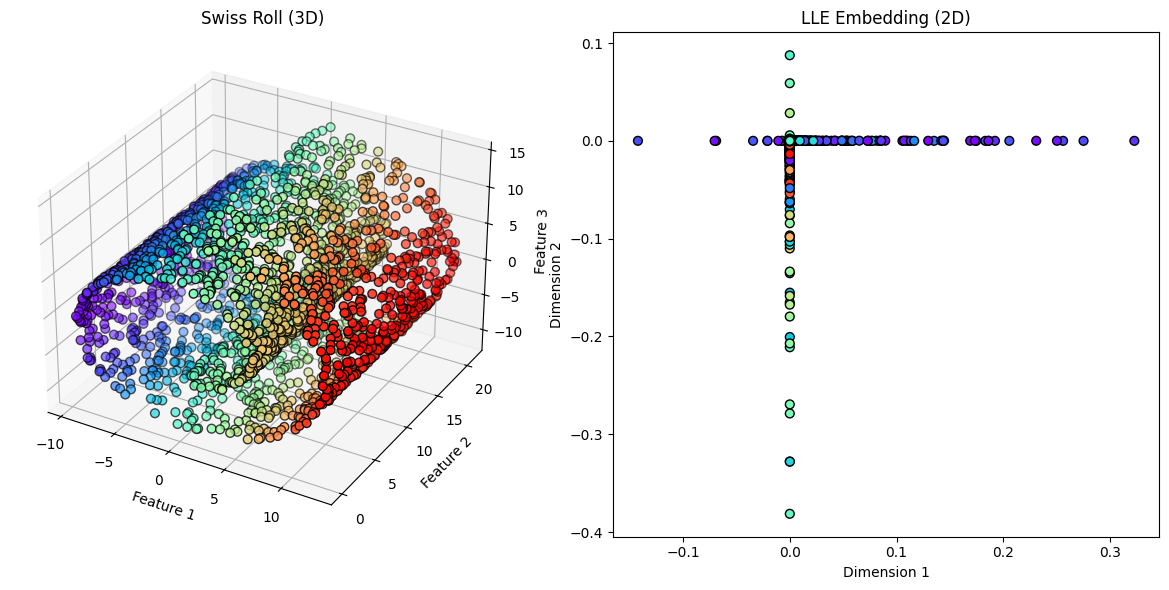

In [8]:
# Generate Swiss roll data
swiss_roll_data = generate_swiss_roll(n_samples=2500, noise=0.05)

# Apply LLE to reduce the Swiss roll to 2 dimensions
embedding_swiss_roll = lle(swiss_roll_data, q=2, k=10, alpha=0.01)

# Plot the original Swiss roll (3D) and the LLE embedding (2D) with rainbow colormap
plot_before_after(swiss_roll_data, embedding_swiss_roll, title_before='Swiss Roll (3D)', title_after='LLE Embedding (2D)')
